In [11]:
from sircuitenum import utils
from sircuitenum import visualize as viz
from sircuitenum import qpackage_interface as qpi
import numpy as np
import sircuitenum.optimize.sweep as swp
import sircuitenum.optimize.diff_evol as de
import scipy as sp
from tqdm import tqdm
import SQcircuit as sq
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed
import qutip as qt
import utils_sq_optimize as ut
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", message="divide by zero")

# Pick two most sensitive params

[9.38371086, 0.2491907, 9.83433136, 0.48106767, 0.89877768, 7.45653507, 0.18848506] 

std= [0.07173770071944112, 0.02138555214253431, 0.1211957316734211, 0.03908229626270533, 0.057963081710796234, 0.1022711173553237, 0.28407094241281955]
the two most parameters index: [1 3 4 0 5 2 6]
two most sensitive param_grid:
 [[9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.16963655400000002], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.17434868050000002], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.17906080700000002], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.1837729335], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.18848506000000004], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.19319718650000003], [9.38371086, 0.2491907, 8.850898224, 0.48106767, 0.89877768, 7.45653507, 0.19790931300000003], [9.38371086, 0.2491907, 

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  46 out of  81 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=100)]: Done  81 out of  81 | elapsed:    1.8s finished


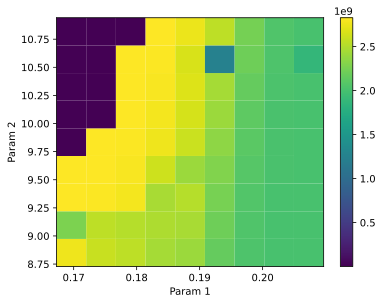

In [40]:
n_grid = 9
df_ngate = pd.read_csv('node3_ngate.csv')
db = "circuits_4_nodes_7_elems.db"
ngate = []
param_best = []
circuit_idx = np.arange(59,60)
# circuit_idx = np.arange(21,22)
for num_node in [3]: # All unique qubits with 2/3/4 nodes    
    df = utils.get_unique_qubits(db, num_node)
    for idx in circuit_idx:
        row = df.iloc[idx]
        args = [row]

        ngate = df_ngate.iloc[idx]['ngate']
        # param_best = list(np.array( df_ngate.iloc[idx]['param'].strip('[]').split(), dtype=float))
        param_best = [9.38371086, 0.2491907, 9.83433136, 0.48106767, 0.89877768,7.45653507, 0.18848506] 
        print(param_best,'\n')

        # Find the two most parameters
        std_vec = []
        for idx,param in enumerate(param_best):
            param_vec = np.linspace(param*0.9, param*1.1, num=n_grid)

            param_grid = []
            for jdx in range(len(param_vec)):
                param_grid.append(param_best[:idx] + [param_vec[jdx]] + param_best[idx+1:])
            ngate_vec = [-ut.get_ngate_anyq(np.array(params), *args) for params in param_grid]

            # print('\n',param_grid)
            std_vec.append(np.std(ngate_vec)/ngate)
            # print('Standard deviation/Ngate=', np.std(ngate_vec)/ngate)
        # sensitive_1 = np.argmax(std_vec)
        index = np.argsort(std_vec)
        print('std=',std_vec)
        print('the two most parameters index:',index)

        # Make a parameter grid using these two most sensitive parameters
        param_1_vec = np.linspace(param_best[index[-1]]*0.9, param_best[index[-1]]*1.1, num=n_grid)
        param_2_vec = np.linspace(param_best[index[-2]]*0.9, param_best[index[-2]]*1.1, num=n_grid)
        param_grid = []
        for mdx in range(n_grid):
            for ndx in range(n_grid):
                if index[-2] < index[-1]:
                    param_grid.append(param_best[:index[-2]]
                     + [param_2_vec[mdx]] + param_best[index[-2]+1:index[-1]]
                     + [param_1_vec[ndx]] + param_best[index[-1]+1:]  )
                else:
                    param_grid.append(param_best[:index[-1]]
                     + [param_2_vec[mdx]] + param_best[index[-1]+1:index[-2]]
                     + [param_1_vec[ndx]] + param_best[index[-2]+1:]  )
        
        print('two most sensitive param_grid:\n', param_grid)
        # print(np.shape(param_grid))

        ngate_vec = Parallel(n_jobs=100, verbose=1)(delayed(ut.get_ngate_anyq)(param, *args)
                                              for param in param_grid )
        ngate_vec = -1* np.array(ngate_vec)
        ngate_map = np.reshape(ngate_vec, (n_grid, n_grid))

        fig, ax = plt.subplots(figsize=(6,4.5))
        plt.pcolormesh(param_1_vec, param_2_vec, ngate_map)
        plt.colorbar()
        plt.xlabel(r"Param 1")
        plt.ylabel(r"Param 2");
        
        # args_sav = [idx, ngate, 
        #             np.mean(ngate_vec), np.mean(ngate_vec)/ngate,
        #             np.std(ngate_vec), np.std(ngate_vec)/ngate,
        #             np.max(np.abs(ngate_vec - ngate))  ]

        # ut.sav_stability(file='node3_ngate_stability_2d.csv', args_sav=args_sav)


# [('J',), ('C', 'J', 'L'), ('C', 'J', 'L')]

# Stability Analysis - Parallel 

In [5]:
df_ngate = pd.read_csv('node3_ngate copy.csv')
db = "circuits_4_nodes_7_elems.db"
ngate = []
param_best = []
circuit_idx = np.arange(1,2)
for num_node in [3]: # All unique qubits with 2/3/4 nodes    
    df = utils.get_unique_qubits(db, num_node)
    for idx in tqdm(circuit_idx):
        row = df.iloc[idx]
        ngate = df_ngate.iloc[idx]['ngate']
        param_best = np.array( df_ngate.iloc[idx]['param'].strip('[]').split(), dtype=float)

        if len(param_best) in [7, 8] or len(param_best) > 8: # 3**8 = 6561, 4**8 = 65536, 
            n_param = 3
        elif len(param_best) in [5, 6]: # 5**6 = 15625, 6**6 = 46656
            n_param = 5
        else: n_param = 10
        param_vec = [np.linspace(param*0.9, param*1.1, num=n_param) for param in param_best]

        args = [row]
        ngate_vec = Parallel(n_jobs=100, verbose=1)(delayed(ut.get_ngate_anyq)(param, *args)
                                              for param in np.array(list(itertools.product(*param_vec))) )
        ngate_vec = -1* np.array(ngate_vec)
        args_sav = [idx, ngate, 
                    np.mean(ngate_vec), np.mean(ngate_vec)/ngate,
                    np.std(ngate_vec), np.std(ngate_vec)/ngate,
                    np.max(np.abs(ngate_vec - ngate))  ]

        ut.sav_stability(args_sav)


  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:    3.7s
[Parallel(n_jobs=100)]: Done 736 tasks      | elapsed:    4.1s
[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed:    4.4s finished
100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


# Stability Analysis

In [6]:
df_ngate = pd.read_csv('node3_ngate copy.csv')
db = "circuits_4_nodes_7_elems.db"
ngate = []
param_best = []
circuit_idx = np.arange(5,6)
for num_node in [3]: # All unique qubits with 2/3/4 nodes    
    df = utils.get_unique_qubits(db, num_node)
    for idx in tqdm(circuit_idx):
        row = df.iloc[idx]
        ngate = df_ngate.iloc[idx]['ngate']
        
        param_best = np.array( df_ngate.iloc[idx]['param'].strip('[]').split(), dtype=float)
        param_vec = [np.linspace(param*0.9, param*1.1, num=10) for param in param_best]
        args = [row]
        ngate_vec = [-ut.get_ngate_anyq(np.array(param), *args) 
                        for param in np.array(list(itertools.product(*param_vec)))]
        print(ngate_vec)
        print('Ngate=',ngate)
        print('Mean=', np.mean(ngate_vec))
        print('Mean/Ngate=', np.mean(ngate_vec)/ngate)
        print('Standard deviation=', np.std(ngate_vec))
        print('Standard deviation/Ngate=', np.std(ngate_vec)/ngate)
        print('Max deviation=', np.max(np.abs(ngate_vec - ngate)))
        # sav_stability(np.shape(param_vec)[1], 
        #                 idx, 
        #                 ngate, 
        #                 np.mean(ngate_vec), 
        #                 np.std(ngate_vec), 
        #                 np.max(np.abs(ngate_vec - ngate)))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

[1999544621.934741, 1999492754.45236, 1999462167.517736, 1999889531.753568, 1999892273.9439304, 1999887073.4703262, 1999906068.3755531, 1999397644.4515724, 1999776881.4626637, 1999740588.483441, 1999916286.1703112, 1999909766.457857, 1999628946.9002821, 1999854577.125146, 1999919425.0251226, 1999874531.7996063, 1999897372.47168, 1999877280.072365, 1999762271.1396825, 1999671129.686891, 1999877746.619082, 1999846546.1306286, 1999816207.5115857, 1999713362.3625176, 1999918435.5743353, 1999599114.3168647, 1999643664.7646444, 1999897941.0363722, 1999897085.2019162, 1999786081.6487916, 1999889916.1706662, 1999794822.8682811, 1999869103.7637885, 1999915641.7926981, 1999890812.4605937, 1999841910.4389565, 1999880431.3847654, 1999867027.822079, 1999897572.8412533, 1999768151.3972726, 1999783336.7530835, 1999874052.0294166, 1999907581.6465847, 1999766742.4042006, 1999874886.115131, 1999525646.8283083, 1999355448.7087512, 1999891083.8807957, 1999901065.8088048, 1999829136.8121984, 1999908026.931

# Optimization


######### Circuit No.0
######### ngate: []
######### param: []


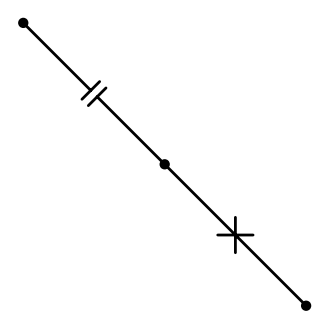

differential_evolution step 1: f(x)= -410427
differential_evolution step 2: f(x)= -410427
differential_evolution step 3: f(x)= -461295
differential_evolution step 4: f(x)= -461295
differential_evolution step 5: f(x)= -461295
differential_evolution step 6: f(x)= -461295
differential_evolution step 7: f(x)= -461295
differential_evolution step 8: f(x)= -461295
differential_evolution step 9: f(x)= -461295
differential_evolution step 10: f(x)= -461295
differential_evolution step 11: f(x)= -461295
differential_evolution step 12: f(x)= -461875
differential_evolution step 13: f(x)= -462071
differential_evolution step 14: f(x)= -462071
differential_evolution step 15: f(x)= -462081
differential_evolution step 16: f(x)= -462100
differential_evolution step 17: f(x)= -462100
differential_evolution step 18: f(x)= -462102
Polishing solution with 'L-BFGS-B'
@@@ Succeed for qubit: NO.0 
  message: Optimization terminated successfully.
 success: True
     fun: -462102.8789572361
       x: [ 6.723e-01  3

In [23]:
db = "circuits_4_nodes_7_elems.db"
ngate = []
param_best = []
circuit_idx = [0] # np.arange(35,36)
for num_node in [3]:
    # All unique qubits with 2/3/4 nodes
    df = utils.get_unique_qubits(db, num_node)
    for idx in circuit_idx:
        print(f'\n######### Circuit No.{idx}')
        print('######### ngate:',ngate)
        print('######### param:',param_best)
        row = df.iloc[idx]
        viz.draw_circuit_diagram(row.circuit, row.edges)
        args = [row]
        ranges = ut.gen_param_range_anyq(row.circuit)
        # print(ranges)
        try:
            res = sp.optimize.differential_evolution(ut.get_ngate_anyq, ranges, workers=1,
                        popsize=30, disp=True,  args=args, updating='immediate',
                        callback=None, maxiter=1000,
                        mutation=(0.1, 1.99), recombination=0.7)
            print(f'@@@ Succeed for qubit: NO.{idx} \n', res)
            ngate.append(-res.fun)
            param_best.append(res.x)

        except:
            print(f"@@@ Error occurred for qubit: NO.{idx}")
            ngate.append(0)
            param_best.append(np.array([0]))
        # sav_ngate(num_node, idx, row.circuit, ngate[-1], param_best[-1])
        print(num_node, idx, ', "', row.circuit, '",', ngate[-1], ',', param_best[-1])


idx = np.argmax(ngate)
row = df.iloc[circuit_idx[idx]]
print('\n----------------------------------------------------')
print(f'best {num_node}-node qubit: \nindex={idx},   Ngate=%.3e'%ngate[idx])
print(f'params: {row.circuit} --- {param_best[idx]}\n')
# viz.draw_circuit_diagram(row.circuit, row.edges)

In [31]:
import pandas as pd
df = pd.read_csv("node3_ngate.csv")
df.sort_values(by="ngate", ascending=False)
df

,circuit,ngate,param,param_std
0,"[('C',), ('J',)]",4.621145e+05,[0.26459067 3. ],"[6.266414609960884e-07, 0.14418635770350702]"
1,"[('C',), ('J', 'L')]",1.063574e+07,[ 0.53307971 18.59204726 0.1 ],"[1.0551535118808603e-10, 0.004203802662555577,..."
2,"[('C',), ('C', 'J')]",3.603056e+05,[0.37096466 0.5615766 3.00166125],"[1.0733702477350591e-11, 0.02345821073910596, ..."
3,"[('C',), ('C', 'J', 'L')]",2.813225e+09,[ 0.47547738 0.72030706 12.29135569 0.10462962],"[7.050786265680061e-07, 0.4138239198199839, 0...."
4,"[('J',), ('J',)]",4.620635e+05,[17.66917222 3.00006244],"[0.00028215759808762126, 0.1439232295672546]"
...,...,...,...,...
83,"[('J', 'L'), ('C', 'J', 'L'), ('C', 'J', 'L')]",2.828127e+09,[11.0786434 0.69538083 0.88973911 18.144870...,NaN
84,"[('C', 'J'), ('C', 'J'), ('C', 'J')]",1.092335e+06,[0.0507199 3.0552755 0.05061676 3.04924945 0...,NaN
85,"[('C', 'J'), ('C', 'J'), ('C', 'J', 'L')]",2.827560e+09,[ 0.35614328 12.44882982 0.71447959 14.018212...,NaN
86,"[('C', 'J'), ('C', 'J', 'L'), ('C', 'J', 'L')]",2.827871e+09,[ 0.38511267 9.24352065 0.40932189 15.564481...,NaN


# Ngate for single qubit

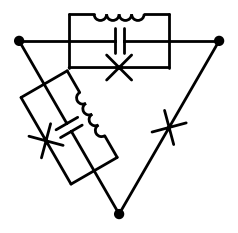

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


t2 0.0005119068064100545


In [35]:
db = "circuits_4_nodes_7_elems.db"
df = utils.get_unique_qubits(db, 3)
row = df.iloc[59]
viz.draw_circuit_diagram(row.circuit, row.edges)
param = ut.gen_param_anyq(row.circuit)
params = ut.gen_param_dict_anyq(row.circuit, row.edges, param)
sqc = qpi.to_SQcircuit(row.circuit, row.edges, params=params)
sqc.description()
sqc.diag(3) # Generate first three states used for lots of stuff
rates = swp.calc_decay_rates(sqc)
t_1, t_phi, t_2 = swp.decoherence_time(rates)
# alpha = swp.get_anharmonicity(sqc)
# gate_time = swp.get_gate_time(alpha, 1/t_1)
# ngates = t_2/gate_time
print('\nt2',t_2)

# Tolerance bug and Parallel sweep for node 3.4

In [ ]:

### Parallel computing
db = "circuits_4_nodes_7_elems.db"
df = utils.get_unique_qubits(db, 3)
row = df.iloc[4]
viz.draw_circuit_diagram(row.circuit, row.edges)
args = [row]

Ej_vec = np.linspace(3., 20., num=101)
n_jobs = 100
values_grid = list(itertools.product(Ej_vec, Ej_vec))
data_grid = Parallel(n_jobs=n_jobs, verbose=1)(delayed(get_ngate_anyq)(value, *args)
                                              for value in values_grid)
np.savez('para_run_fn_name1.npz', x1 = Ej_vec,
         x2 = Ej_vec, vals = values_grid, fn_vals = data_grid)
data_x_y = np.load('para_run_fn_name1.npz','r')
print("\"Keys\" of the data: ", list(data_x_y.keys()) )
delts = data_x_y['x1']
gams = data_x_y['x2']
vals = data_x_y['vals']
ngate = data_x_y['fn_vals']

ngate = np.reshape(ngate, (len(Ej_vec), len(Ej_vec)))
(Ej1_vec, Ej2_vec) = np.unravel_index(np.argmax(ngate, axis=None), np.shape(ngate))

# Tolerance bug and Parameter sweep for node 3.4

In [ ]:
db = "circuits_4_nodes_7_elems.db"
df = utils.get_unique_qubits(db, 3)
row = df.iloc[4]
viz.draw_circuit_diagram(row.circuit, row.edges)
args = [row]
ranges = gen_param_range_anyq(row.circuit)

ngate = []
Ej_vec = np.linspace(3., 20., num=101)
for Ej1 in tqdm(Ej_vec):
    for Ej2 in Ej_vec:
        # print(Ej1,Ej2)
        ngate.append(get_ngate_anyq([Ej1, Ej2], *args))
print(ngate)
ngate = np.reshape(ngate, (len(Ej_vec), len(Ej_vec)))
# plt.imshow(ngate)

In [ ]:
db = "circuits_4_nodes_7_elems.db"
for num_node in [2,3,4]:
    df = utils.get_unique_qubits(db, num_node)
    print(len(df))

# Flux loop bug

In [ ]:
db = "circuits_4_nodes_7_elems.db"
df = utils.get_unique_qubits(db, 3)
row = df.iloc[85]
viz.draw_circuit_diagram(row.circuit, row.edges)
param = gen_param_anyq(row.circuit)
params = gen_param_dict_anyq(row.circuit, row.edges, param)

print(row.circuit, '\n', row.edges, '\n', params)
sqc = qpi.to_SQcircuit(row.circuit, row.edges, params=params)
# sqc.loop_description()
sqc.description()

sqc.diag(3) # Generate first three states used for lots of stuff
# rates = swp.calc_decay_rates(sqc)
# t_1, t_phi, t_2 = swp.decoherence_time(rates)
# alpha = swp.get_anharmonicity(sqc)
# gate_time = swp.get_gate_time(alpha, 1/t_1)
# ngates = t_2/gate_time
# print(ngates)